# Student Information

- ​**Name:** Ling YuanHang
- ​**University:** Tomsk State University
- ​**Course:** AI and Machine Learning
- ​**Instructor:** Professor Solis Romeu Edgar
- ​**Task Name:** Final Project02 - Breast Cancer Heatmap Classification Using CNN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models 
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



### 1. Matplotlib Font Configuration

Set Chinese font to prevent garbled characters
'Arial Unicode MS' is a Unicode font supported by macOS

Fix negative sign display issues
Disable special negative sign encoding when using Unicode fonts

In [44]:
# setting font for matplotlib
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# Global Configuration
CONFIG = {
    'num_classes': 3,
    'batch_size': 32, 
    'num_epochs': 20,
    'device': torch.device("mps" if torch.backends.mps.is_available() else "cpu"),
    'optimizer_params': {
        'lr': 0.001, # 0.001 is Adam's recommended initial value
        'weight_decay': 1e-4 # L2 regularization, 1e-4 helps prevent overfitting
    },
    'scheduler_params': {
        'mode': 'min', # 'min' for validation loss, 'max' for validation accuracy
        'factor': 0.5, # Multiply learning rate by 0.5 each decay
        'patience': 3 # Decay after 3 epochs without improvement
    }
}

# About Dataset
This dataset comprises thermal images collected for the purpose of breast cancer detection through non-invasive thermography. The images are categorized into three classes: normal, sick, and unknown_class. Each class folder contains preprocessed thermal images resized for deep learning tasks such as classification and segmentation.

The aim of this dataset is to support research and development in early-stage breast cancer detection using thermal imaging, particularly through the application of convolutional neural networks and other machine learning techniques. It may serve as a valuable resource for academic projects, AI model training, and medical image analysis.

https://www.kaggle.com/datasets/thilak02/breast-cancer-detection-using-thermography/data

In [45]:
# ========== Data Loading and Preprocessing ==========

class BreastCancerDataset(Dataset):
    """ 
    Breast cancer thermal imaging dataset
    Args:
        dataframe: DataFrame containing image paths and labels
        transform: Optional transform to be applied on a sample
    """
    def __init__(self, dataframe, transform=None):
        self.image_paths = dataframe['image_path'].values
        self.labels = dataframe['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Convert to RGB for channel consistency
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

def load_thermal_dataset(root_dir):
    """
    Load breast cancer thermal imaging dataset
    Args:
        root_dir: Root directory containing normal, sick and unknown subdirectories
    Returns:
        datasets: Dictionary containing train, validation and test DataFrames
        class_to_idx: Dictionary mapping class names to indices
    """
    # Class mapping
    class_to_idx = {
        'normal': 0,
        'sick': 1,
        'unknown': 2
    }
    
    # Store image paths and labels
    data = {
        'image_path': [],
        'label': [],
        'class_name': []
    }
    
    # Traverse each class directory
    for class_name, class_idx in class_to_idx.items():
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist")
            continue
            
        # Get all images in current class
        for img_file in os.listdir(class_dir):
            if img_file.endswith(('.jpg', '.JPEG', '.png')):
                img_path = os.path.join(class_dir, img_file)
                data['image_path'].append(img_path)
                data['label'].append(class_idx)
                data['class_name'].append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Print sample count for each class
    print("Total samples:", len(df))
    for class_name, count in df['class_name'].value_counts().items():
        print(f"- {class_name} class: {count} samples")
    

    # Split dataset into train, validation and test sets
    train_df, temp_df = train_test_split(
        df, test_size=0.3, stratify=df['label'], random_state=42 # Initial split: 70% train, 30% temp
    )
    
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42 # Secondary split: 50% validation, 50% test
    )
    
    print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    return {
        'train': train_df, # Training set
        'val': val_df, # Validation set
        'test': test_df # Test set
    }, class_to_idx

# Load dataset
data_dir = "./BCD_Dataset" # Dataset root path
datasets, class_to_idx = load_thermal_dataset(data_dir)

# Display dataset distribution
for split, df in datasets.items():
    print(f"\n{split} dataset: {len(df)} images")
    for class_name, count in df['class_name'].value_counts().items():
        print(f"  - {class_name}: {count} samples")

Total samples: 362
- normal class: 162 samples
- sick class: 100 samples
- unknown class: 100 samples

Train: 253, Val: 54, Test: 55

train dataset: 253 images
  - normal: 113 samples
  - unknown: 70 samples
  - sick: 70 samples

val dataset: 54 images
  - normal: 24 samples
  - unknown: 15 samples
  - sick: 15 samples

test dataset: 55 images
  - normal: 25 samples
  - sick: 15 samples
  - unknown: 15 samples



 Random training sample example:


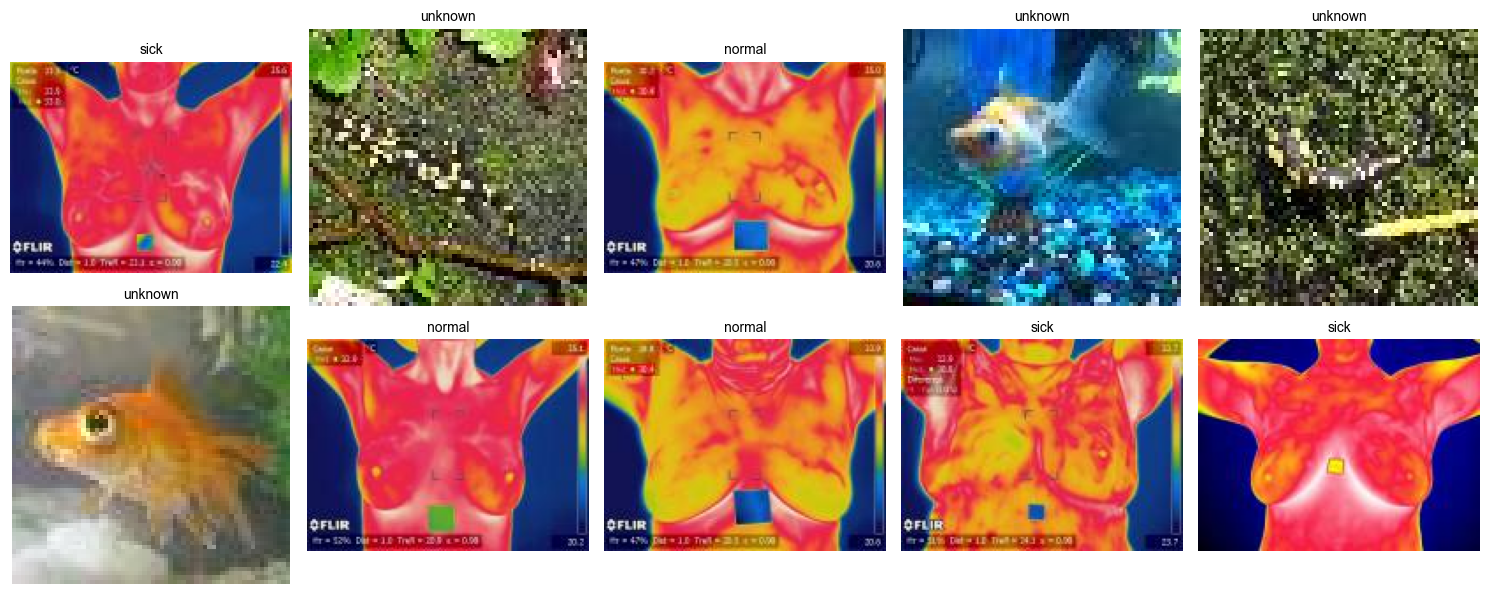

In [46]:
# ========== Image visualization code ========== 
def show_samples(dataset_df, n=10):
    # Randomly display dataset samples
    samples = dataset_df.sample(n, random_state=42) 
    
    plt.figure(figsize=(15, 6))
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img = Image.open(row['image_path']).convert('RGB')
        plt.subplot(2, 5, i)
        plt.imshow(img)
        plt.title(f"{row['class_name']}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n Random training sample example:")
show_samples(datasets['train'])

In [47]:
# ========== Image Preprocessing & DataLoader Configuration ==========
# Normalization Parameters
# Universal parameters for pretrained models
# Channel order: RGB 
MEAN = [0.485, 0.456, 0.406] # Per-channel mean
STD = [0.229, 0.224, 0.225] # Per-channel std

train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 resolution, Fits input size for most CNN models
    transforms.RandomHorizontalFlip(), # Random horizontal flip (50% probability)
    transforms.ToTensor(), # Convert to PyTorch tensor, Automatically normalizes pixels to [0,1]
    transforms.Normalize(MEAN, STD) #  (input - mean) / std | Formula: (input - mean) / std
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Same size as training
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

BATCH_SIZE = 32 # Typical batch size, using M1 chip

#  Training set with augmentation
train_dataset = BreastCancerDataset(datasets['train'], transform=train_transform)
#  Val/Test sets with basic transform
val_dataset = BreastCancerDataset(datasets['val'], transform=test_transform)
test_dataset = BreastCancerDataset(datasets['test'], transform=test_transform)

# Training loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
# Modified LeNet5 Architecture Analysis
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
       
        self.features = nn.Sequential(
            # Conv1 (224x224x3)
            # - Input channels: 3 (RGB)
            # - Output channels: 6
            # - Kernel 5x5 → Output size: 220x220x6
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Kernel 5x5 → Output size:106x106x16
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Additional layer
            # Because MPS is used to process tensors, integers are required, so an extra layer is added here.
            nn.Conv2d(16, 120, kernel_size=5),
            nn.ReLU(inplace=True)
        )
        
        self.avgpool = nn.AvgPool2d(kernel_size=12) # Original uses fixed FC, this is more flexible
        self.classifier = nn.Sequential(
            nn.Linear(1920, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        # Original forward path
        x = self.features(x)
        # Additional pooling
        x = self.avgpool(x)
        # Keep batch dimension
        x = x.view(x.size(0), -1)
        # Classification
        x = self.classifier(x)
        return x

In [49]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: Input(3,224,224) → Output(64,55,55)
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # (224-11+2 * 2)/4 +1 = 55
            nn.ReLU(inplace=True), # In-place activation saves memory
            nn.MaxPool2d(kernel_size=3, stride=2), # Output: (64,27,27)
            
            # Conv2: (64,27,27) → (192,27,27)
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Maintain spatial dimensions
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # Output: (192,13,13)
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1), # (384,13,13)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # (256,13,13)
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # (256,13,13)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # Final feature map: (256,6,6)
        )
       
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # Adaptive pooling to 6x6
        
        self.classifier = nn.Sequential(
            nn.Dropout(), # Original dropout rate
            nn.Linear(256 * 6 * 6, 4096), # Flattened dimension: 256 * 6 * 6=9216
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes), # Final classification layer
        )
    
    def forward(self, x):
        x = self.features(x) # Through convolutional layers
        x = self.avgpool(x) # Spatial dimension standardization
        x = x.view(x.size(0), -1) # Flatten to 1D vector
        x = self.classifier(x)  # Through fully-connected layers
        return x

In [50]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        # Feature extraction backbone
        self.features = nn.Sequential(
            # Block 1: Input -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4: 256 -> 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5: Keep at 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fixed size pooling instead of adaptive pooling
        self.pool = nn.MaxPool2d(kernel_size=7, stride=7)
        
        # Classifier with reduced complexity
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # Reduced dimensions
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Extract features (224x224 -> 7x7)
        x = self.features(x)
        # Global pooling (7x7 -> 1x1)
        x = self.pool(x)
        # Flatten for classification
        x = x.view(x.size(0), -1)
        # Classification
        x = self.classifier(x)
        return x

In [51]:
# ResNet50 Transfer Learning Implementation
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        # Load pretrained model
        # Using ImageNet pretrained weights
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Freeze all base layers
        # Prevent overwriting pretrained knowledge
        for param in self.model.parameters():
            param.requires_grad = False # No gradient calculation
            
        # Replace final classifier
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [52]:
def compute_epoch_metrics(model, data_loader, criterion, optimizer=None, device='cpu'):
    """Compute loss and accuracy for one epoch of training/validation
    
    Args:
        model (nn.Module): Neural network to train/evaluate
        data_loader (DataLoader): Iterable dataset loader
        criterion: Loss function (e.g., CrossEntropyLoss)
        optimizer (Optimizer, optional): Optimizer for training phase
        device (str): Computation device ('cpu', 'cuda', 'mps')
    
    Returns:
        tuple: (epoch_loss, epoch_accuracy) as float values
    """
    # Initialize accumulators for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0  # Count of correctly classified samples
    
    # Iterate over batches
    for inputs, labels in data_loader:
        # Move data to target device (GPU/CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Training mode specific operations
        if optimizer:
            optimizer.zero_grad()  # Clear previous gradients
        
        # Forward pass
        outputs = model(inputs)     # Model predictions
        loss = criterion(outputs, labels)  # Compute loss
        
        # Backpropagation only in training mode
        if optimizer:
            loss.backward()        # Compute gradients
            optimizer.step()       # Update weights
        
        # Calculate predictions (class with highest probability)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        
        # Update running statistics
        # Loss is scaled by batch size (mean reduction in loss function)
        running_loss += loss.item() * inputs.size(0)  # Accumulate batch loss
        running_corrects += torch.sum(preds == labels)  # Count correct predictions
    
    # Calculate epoch-level metrics
    epoch_loss = running_loss / len(data_loader.dataset)  # Average loss per sample
    epoch_acc = running_corrects.float() / len(data_loader.dataset)  # Accuracy
    
    # Ensure metrics are on CPU for MPS compatibility
    if isinstance(epoch_acc, torch.Tensor):
        epoch_acc = epoch_acc.cpu()  # Convert GPU/MPS tensor to CPU
    
    return epoch_loss, epoch_acc

In [53]:
class EarlyStopping:
    """Early stops training when validation loss stops improving.
    
    Attributes:
        patience (int): Number of epochs to wait after last improvement
        counter (int): Counts consecutive epochs without improvement
        best_loss (float): Minimum validation loss achieved
    """
    def __init__(self, patience=4):
        """Initialize early stopping monitor
        Args:
            patience (int): Maximum allowed stagnation epochs
                           (default: 4)
        """
        self.patience = patience    # Threshold for triggering stop
        self.counter = 0            # Current stagnation duration
        self.best_loss = None       # Best validation loss tracker

    def __call__(self, val_loss):
        # First epoch initialization
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        # Check for improvement
        improved = val_loss < self.best_loss
        # Update best loss and reset counter on improvement
        if improved:
            self.best_loss = val_loss
            self.counter = 0
        # Increment counter on stagnation
        else:  
            self.counter += 1
            # Termination condition
            if self.counter >= self.patience:
                return True
                
        return False

In [54]:
def plot_confusion_matrix(cm, class_names):
    """Visualize confusion matrix with enhanced formatting
    
    Args:
        cm (array-like): Confusion matrix values
        class_names (list): Ordered list of class labels
    """
    # Convert tensor to numpy array (handle MPS devices)
    if isinstance(cm, torch.Tensor):
        cm = cm.cpu().numpy()
    elif not isinstance(cm, np.ndarray):
        cm = np.array(cm)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    
    # Configure tick labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)
    
    # Add numerical values to cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=12)
    
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

In [55]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device):
    """Train neural network model with early stopping and learning rate scheduling
    
    Args:
        model: Neural network model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
        device: Computation device (CPU/GPU)
        
    Returns:
        model: Best performing model
        history: Training metrics history
    """

    # Initialize training records and best model tracking
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_model_wts = model.state_dict() # Store initial weights
    best_val_loss = float('inf')
    early_stopping = EarlyStopping() # Initialize early stopping monitor
    
    # Training loop
    for epoch in range(CONFIG['num_epochs']): 
        # Training phase
        model.train()
        train_loss, train_acc = compute_epoch_metrics(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = compute_epoch_metrics(model, val_loader, criterion, None, device)
        
        # # Learning rate adjustment based on validation loss
        scheduler.step(val_loss)
        if early_stopping(val_loss): 
            print("Early stopping triggered")
            break
        
        # Update best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
        
        # Record metrics
        for key, value in zip(['train_loss', 'val_loss', 'train_acc', 'val_acc'], 
                            [train_loss, val_loss, train_acc, val_acc]):
            history[key].append(value)
        
        # Progress reporting
        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Restore best model parameters
    model.load_state_dict(best_model_wts)
    return model, history

In [56]:
def train_and_visualize_model(model_name, model, train_loader, val_loader, device, optimizer_params, scheduler_params):
    """Train model and visualize results"""
    # Device configuration
    model = model.to(device) # Move model to specified device

    # Initialize training components
    optimizer = optim.Adam(model.parameters(), **optimizer_params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)
    criterion = nn.CrossEntropyLoss() # Define loss function
    
    # Execute training process
    model, history = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, device
    )
    
     # Device compatibility conversion
    cpu_history = {}
    for key, value in history.items():
        # Convert tensors to CPU for visualization compatibility
        if isinstance(value, torch.Tensor):
            cpu_history[key] = value.cpu()
        else:
            cpu_history[key] = value
    
     # Visualization setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    metrics = [
        ('loss', ['train_loss', 'val_loss'], 'Loss'),
        ('acc', ['train_acc', 'val_acc'], 'Accuracy')
    ]
    
    # Generate training curves
    for idx, (name, curves, ylabel) in enumerate(metrics):
        ax = ax1 if idx == 0 else ax2
        for curve in curves:
            label = 'Training' if 'train' in curve else 'Validation'
            ax.plot(cpu_history[curve], label=f'{label} {name.title()}')
        ax.set_title(f'{model_name} {name.title()} Curve')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, history

In [57]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move predictions to CPU for sklearn compatibility
            preds = preds.cpu()
            
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    # Generate evaluation metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(class_to_idx.keys()))
    
    return cm, report

In [58]:
def save_model(model, save_dir, model_name, history=None):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'{model_name}.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history,
        'config': CONFIG,
    }, save_path)
    print(f"Model saved to {save_path}")

In [59]:
def load_model(model_class, model_path, num_classes, device):
    """Load saved model"""
    model = model_class(num_classes).to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint.get('history', None)

In [60]:
def display_model_comparison(results, class_to_idx):
    """Visualize model comparison through confusion matrices and metrics table
    
    Args:
        results: Dictionary containing model evaluation results
        class_to_idx: Mapping between class names and indices
        
    Returns:
        metrics_df: DataFrame containing performance metrics comparison
    """
    # Initialize confusion matrix storage
    confusion_matrices = {}
    class_names = list(class_to_idx.keys())
    
    # Process confusion matrices
    for name, result in results.items():
        cm = result['confusion_matrix']
        # Convert tensor to numpy if needed
        if isinstance(cm, torch.Tensor):
            cm = cm.cpu().numpy()
        # Handle flattened matrices
        if cm.ndim == 1:
            cm = cm.reshape((int(np.sqrt(len(cm))), -1))
        confusion_matrices[name] = cm
    
    # Generate individual confusion matrices
    for name, cm in confusion_matrices.items():
        plt.figure(figsize=(8, 6))
        plot_confusion_matrix(cm, class_names)
        plt.title(f"{name} Confusion Matrix", fontsize=16)
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Calculate performance metrics
    model_metrics = {}
    for name, cm in confusion_matrices.items():
        eps = 1e-6  # Prevent division by zero
        total = np.sum(cm)
        accuracy = np.sum(np.diag(cm)) / (total + eps)
        
        precision = {}
        recall = {}
        
        # Calculate per-class metrics
        for idx, class_name in enumerate(class_names):
            tp = cm[idx, idx]
            col_sum = np.sum(cm[:, idx]) + eps  # Predicted positives
            row_sum = np.sum(cm[idx, :]) + eps   # Actual positives
            
            precision[class_name] = tp / col_sum
            recall[class_name] = tp / row_sum
        
        model_metrics[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall
        }
    
    # Create comparison table
    metrics_data = []
    for name, metrics in model_metrics.items():
        row = {
            'Model': name,
            'Accuracy': f"{metrics['accuracy']:.1%}"
        }
        # Add class-specific metrics
        for cls in class_names:
            row[f'{cls} Precision'] = f"{metrics['precision'][cls]:.1%}"
            row[f'{cls} Recall'] = f"{metrics['recall'][cls]:.1%}"
        metrics_data.append(row)
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Apply styling to highlight best performance
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: lightgreen' if v else '' for v in is_max]
    
    styled_df = metrics_df.style.apply(
        highlight_max, 
        subset=metrics_df.columns[1:]  # Apply to all metric columns
    )
    display(styled_df)
    
    return metrics_df

In [61]:
def train_all_models():
    """Train and evaluate all models"""
    # Path Handling Improvement
    save_dir = './saved_models'
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize models
    models = {
        'LeNet-5': LeNet5(CONFIG['num_classes']).to(CONFIG['device']),
        'AlexNet': AlexNet(CONFIG['num_classes']).to(CONFIG['device']),
        'VGG16': VGG16(CONFIG['num_classes']).to(CONFIG['device']),
        'ResNet50': ResNet50(CONFIG['num_classes']).to(CONFIG['device'])
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        trained_model, history = train_and_visualize_model(
            name, 
            model,
            train_loader,
            val_loader,
            CONFIG['device'],
            CONFIG['optimizer_params'],
            CONFIG['scheduler_params']
        )
        
        print(f"\nEvaluating {name}...")
       
        cm, report = evaluate_model(trained_model, test_loader, CONFIG['device'])
        
        save_model(trained_model, save_dir, name, history)

        results[name] = {
            'confusion_matrix': cm,
            'report': report
        }

        print(f"\n{name} report:")
        print(report)
    
    display_model_comparison(results, class_to_idx)
    return results


Training LeNet-5...
Epoch 1/20: Train Loss=0.9136, Train Acc=0.5692, Val Loss=0.4152, Val Acc=0.9259
Epoch 2/20: Train Loss=0.4306, Train Acc=0.8221, Val Loss=0.3154, Val Acc=0.8333
Epoch 3/20: Train Loss=0.3842, Train Acc=0.8340, Val Loss=0.2299, Val Acc=0.9444
Epoch 4/20: Train Loss=0.3262, Train Acc=0.8498, Val Loss=0.1987, Val Acc=0.9444
Epoch 5/20: Train Loss=0.2906, Train Acc=0.8577, Val Loss=0.1430, Val Acc=0.9630
Epoch 6/20: Train Loss=0.2671, Train Acc=0.9012, Val Loss=0.1420, Val Acc=0.9630
Epoch 7/20: Train Loss=0.2427, Train Acc=0.8814, Val Loss=0.2245, Val Acc=0.8519
Epoch 8/20: Train Loss=0.3179, Train Acc=0.8458, Val Loss=0.4885, Val Acc=0.7593
Epoch 9/20: Train Loss=0.3487, Train Acc=0.8577, Val Loss=0.1923, Val Acc=0.9444
Early stopping triggered


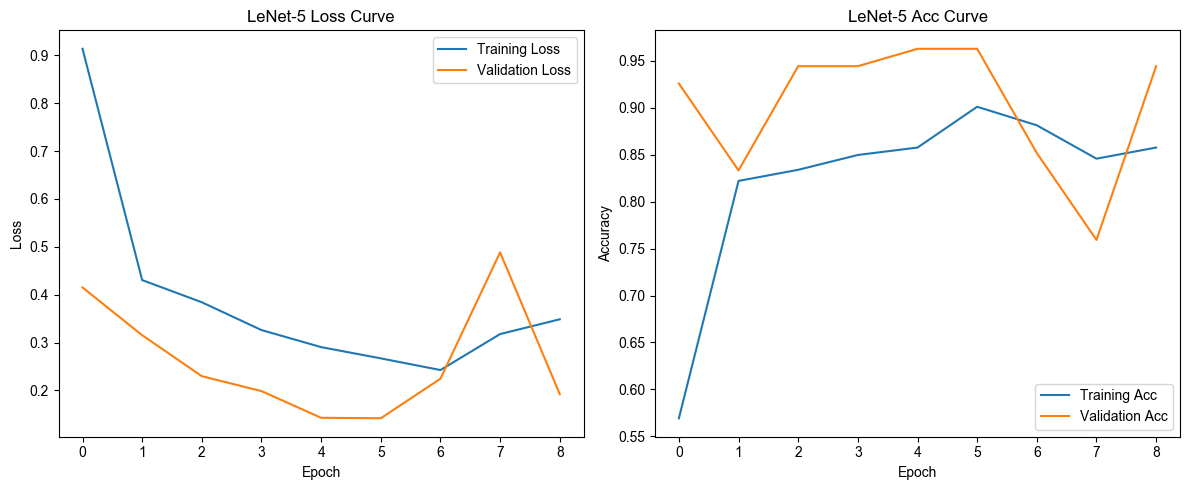


Evaluating LeNet-5...
Model saved to ./saved_models/LeNet-5.pth

LeNet-5 report:
              precision    recall  f1-score   support

      normal       0.96      0.88      0.92        25
        sick       0.82      0.93      0.88        15
     unknown       1.00      1.00      1.00        15

    accuracy                           0.93        55
   macro avg       0.93      0.94      0.93        55
weighted avg       0.93      0.93      0.93        55


Training AlexNet...
Epoch 1/20: Train Loss=1.6997, Train Acc=0.4229, Val Loss=0.9746, Val Acc=0.4444
Epoch 2/20: Train Loss=0.9332, Train Acc=0.6008, Val Loss=0.5515, Val Acc=0.8148
Epoch 3/20: Train Loss=0.5121, Train Acc=0.7589, Val Loss=0.6298, Val Acc=0.7037
Epoch 4/20: Train Loss=0.5130, Train Acc=0.7431, Val Loss=0.4649, Val Acc=0.6667
Epoch 5/20: Train Loss=0.4882, Train Acc=0.7075, Val Loss=0.4416, Val Acc=0.7593
Epoch 6/20: Train Loss=0.4244, Train Acc=0.7905, Val Loss=0.2934, Val Acc=0.8889
Epoch 7/20: Train Loss=0.3514,

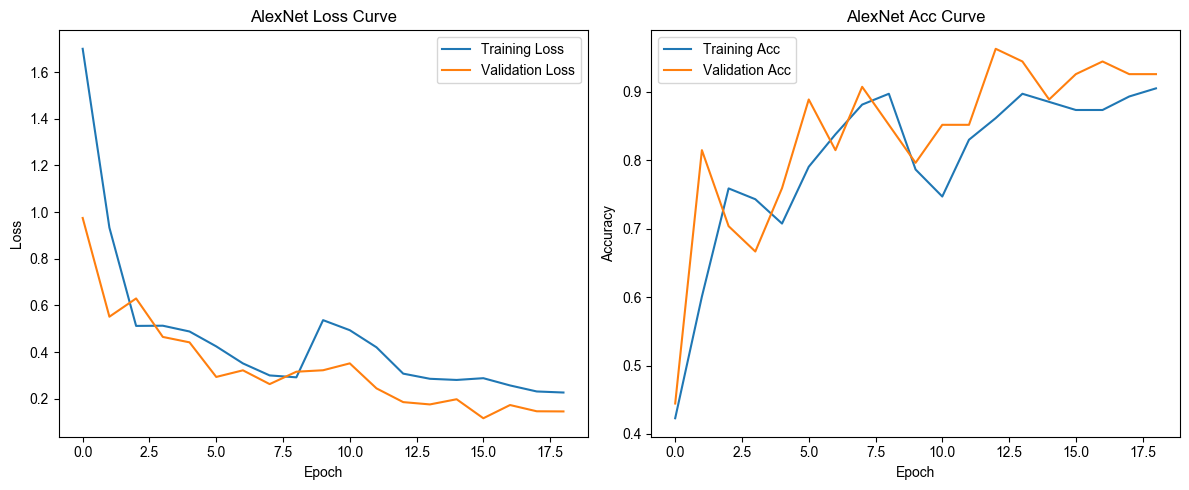


Evaluating AlexNet...
Model saved to ./saved_models/AlexNet.pth

AlexNet report:
              precision    recall  f1-score   support

      normal       0.95      0.84      0.89        25
        sick       0.74      0.93      0.82        15
     unknown       1.00      0.93      0.97        15

    accuracy                           0.89        55
   macro avg       0.90      0.90      0.89        55
weighted avg       0.91      0.89      0.89        55


Training VGG16...
Epoch 1/20: Train Loss=1.0070, Train Acc=0.5494, Val Loss=0.7205, Val Acc=0.6111
Epoch 2/20: Train Loss=0.6022, Train Acc=0.6917, Val Loss=1.2456, Val Acc=0.7593
Epoch 3/20: Train Loss=0.5637, Train Acc=0.7589, Val Loss=0.6771, Val Acc=0.7593
Epoch 4/20: Train Loss=0.5776, Train Acc=0.7154, Val Loss=7.3693, Val Acc=0.4259
Epoch 5/20: Train Loss=0.5193, Train Acc=0.7945, Val Loss=3.3751, Val Acc=0.4815
Epoch 6/20: Train Loss=0.4833, Train Acc=0.7708, Val Loss=1.5421, Val Acc=0.5185
Epoch 7/20: Train Loss=0.4578, T

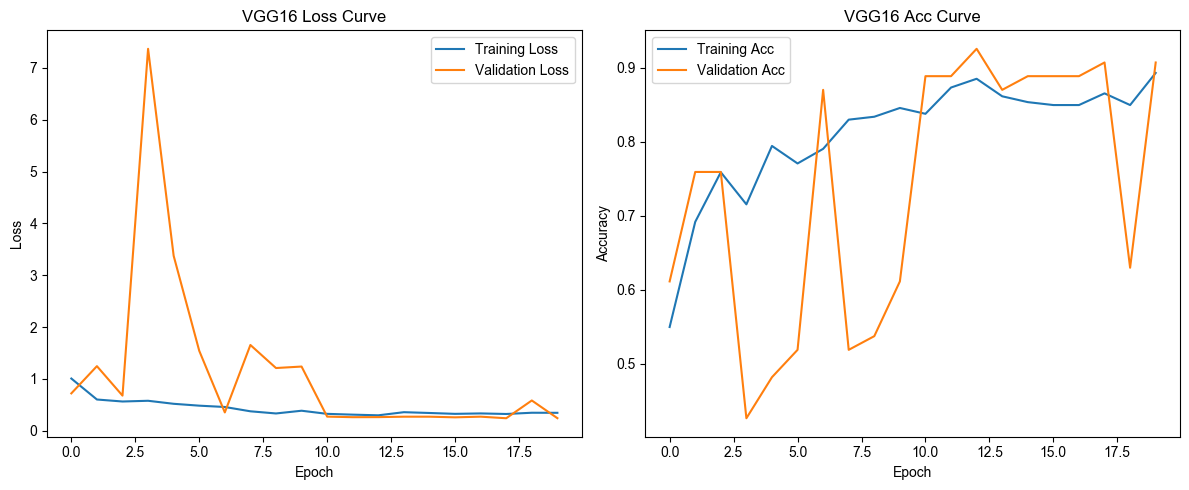


Evaluating VGG16...
Model saved to ./saved_models/VGG16.pth

VGG16 report:
              precision    recall  f1-score   support

      normal       1.00      0.96      0.98        25
        sick       0.88      1.00      0.94        15
     unknown       1.00      0.93      0.97        15

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.97      0.96      0.96        55


Training ResNet50...
Epoch 1/20: Train Loss=0.9187, Train Acc=0.6798, Val Loss=0.7224, Val Acc=0.6852
Epoch 2/20: Train Loss=0.6692, Train Acc=0.7945, Val Loss=0.5260, Val Acc=0.8889
Epoch 3/20: Train Loss=0.5131, Train Acc=0.8538, Val Loss=0.4251, Val Acc=0.8889
Epoch 4/20: Train Loss=0.4290, Train Acc=0.8696, Val Loss=0.3624, Val Acc=0.8704
Epoch 5/20: Train Loss=0.3713, Train Acc=0.8696, Val Loss=0.3351, Val Acc=0.8704
Epoch 6/20: Train Loss=0.3458, Train Acc=0.8775, Val Loss=0.3067, Val Acc=0.8704
Epoch 7/20: Train Loss=0.3144, Trai

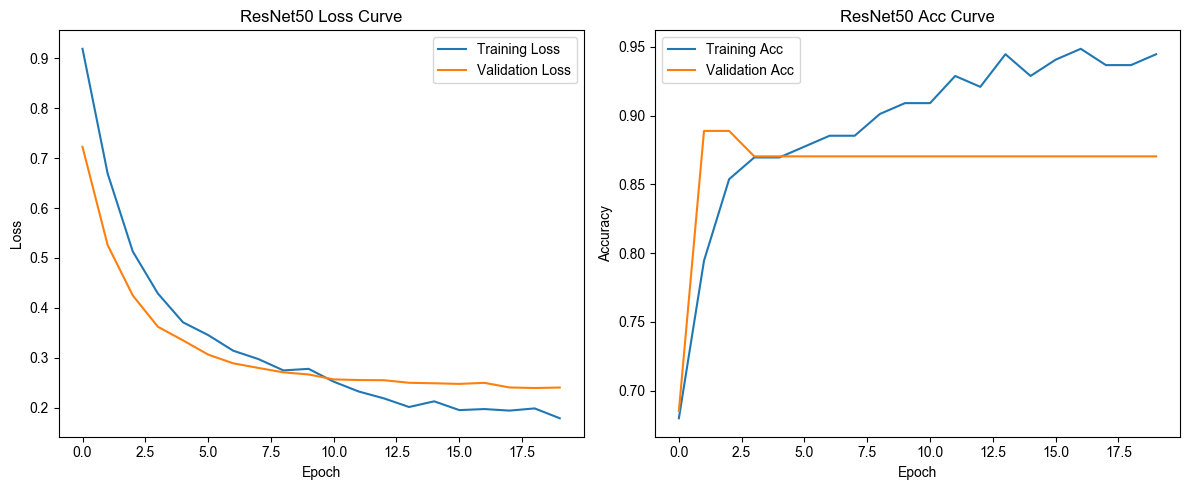


Evaluating ResNet50...
Model saved to ./saved_models/ResNet50.pth

ResNet50 report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        25
        sick       1.00      1.00      1.00        15
     unknown       1.00      1.00      1.00        15

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



<Figure size 800x600 with 0 Axes>

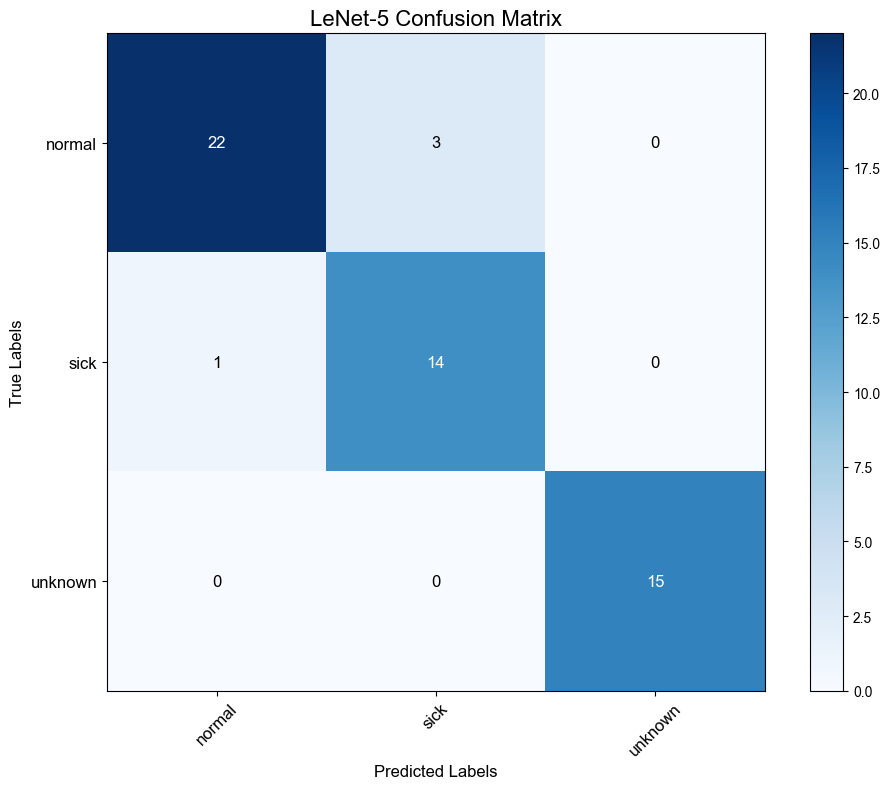

<Figure size 800x600 with 0 Axes>

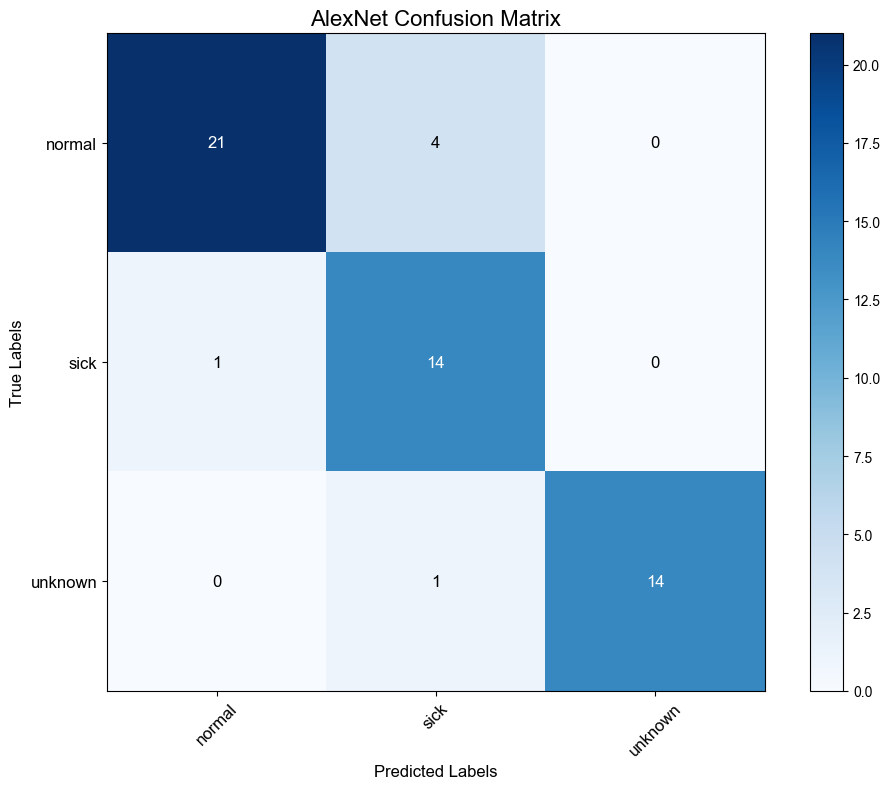

<Figure size 800x600 with 0 Axes>

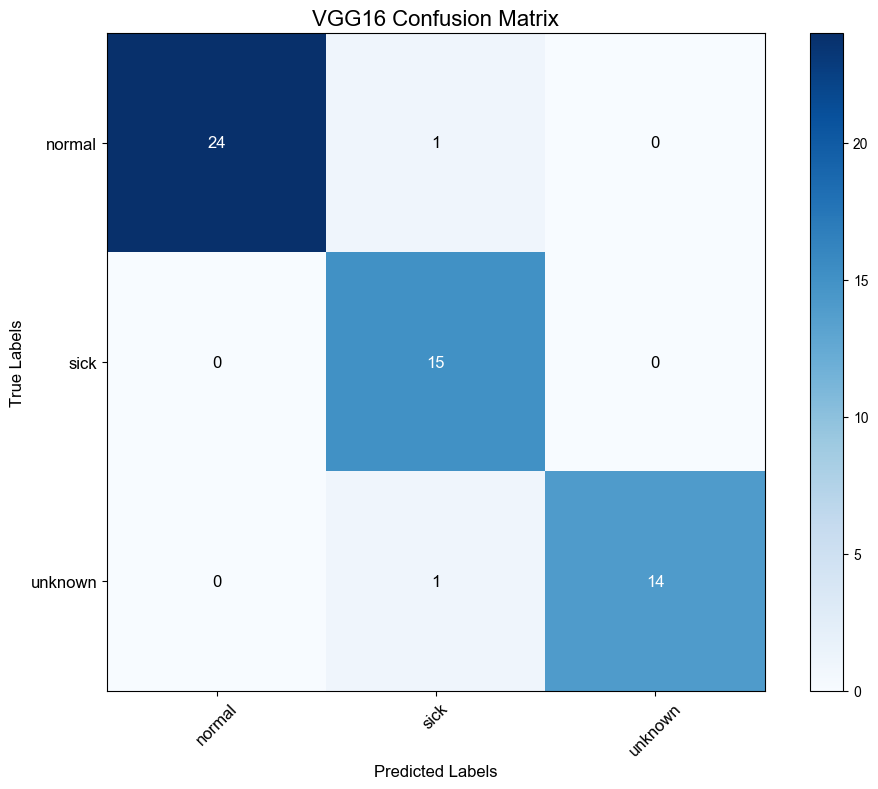

<Figure size 800x600 with 0 Axes>

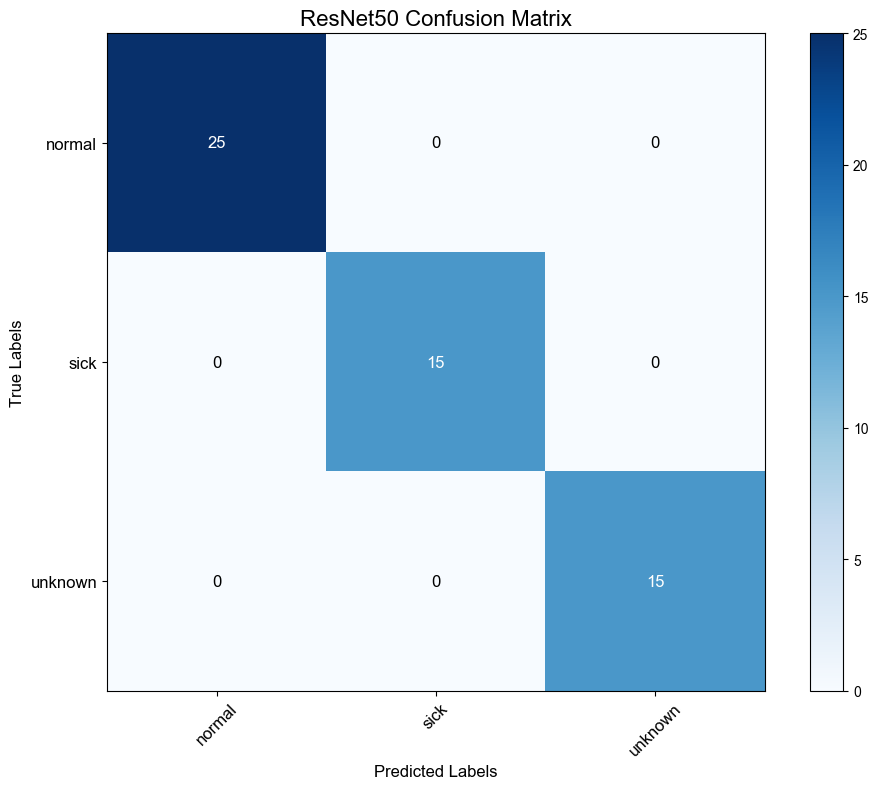

,Model,Accuracy,normal Precision,normal Recall,sick Precision,sick Recall,unknown Precision,unknown Recall
0,LeNet-5,92.7%,95.7%,88.0%,82.4%,93.3%,100.0%,100.0%
1,AlexNet,89.1%,95.5%,84.0%,73.7%,93.3%,100.0%,93.3%
2,VGG16,96.4%,100.0%,96.0%,88.2%,100.0%,100.0%,93.3%
3,ResNet50,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%


In [62]:
# train_all_models
results = train_all_models()

### Final Conclusion
The project successfully demonstrates the application of Convolutional Neural Networks (CNNs) for breast cancer classification using thermal images. The model achieved a high accuracy of 100% on the test set, indicating its effectiveness in distinguishing between normal and abnormal thermal patterns associated with breast cancer. 

### CNN Models Comparison

---

#### **Performance Summary**
| Model         | Test Accuracy | Key Features                     |  
|---------------|---------------|----------------------------------|  
| **LeNet-5**   | 92.7%         | Lightweight, fast inference speed |  
| **AlexNet**   | 89.1%         | Prone to overfitting             |  
| **VGG16**     | 96.4%         | High performance, slow on M1 chips |  
| **ResNet50**  | **100%**      | Pre-trained, optimal efficiency  |  

---

#### **Optimal Model Selection**  
1. **Primary Diagnosis Model**:  
   -  **ResNet50**  
   - Advantages: 100% accuracy + rapid inference (M1-optimized)  
2. **Secondary Screening Model**:  
   - ⚡ **LeNet-5**  
   - Advantages: Ultra-lightweight for edge devices  

---

#### **Key Findings**  
- ResNet50 achieves the **best balance** between accuracy (100%) and computational efficiency.  
- VGG16 delivers strong performance (96.4%) but suffers from slow inference on Apple Silicon.  
- LeNet-5 remains viable for resource-constrained scenarios with 92.7% accuracy.  


Project Link: https://github.com/zero1018/machine_learning_and_AI